Projekt przygotowany przez Mateusza Mularskiego z grupy 2TD11B
Przygotowany on został w oparciu o bazę danych oraz skrypty tworzące ją dostępne pod linkiem:
     https://www.kaggle.com/datasets/fatismajli/ufc-data
            
Celem projektu jest analiza statystyk oraz przygotowanie modelu predykcji zwycięzcy
w oparciu o dostępne dane.

Zaimportowanie bibliotek oraz wczytanie plików z danymi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
import seaborn as sns

events = pd.read_csv("ufc_event_data.csv")
fighters = pd.read_csv("ufc_fighters.csv")

In [19]:
# Zamiana wagi z lbs na kg
fighters['Weight'] = fighters['Weight'].apply(lambda x: float(x.split()[0]) * 0.453592 if isinstance(x, str) and x != '--' else np.nan)

# Zamiana wzrostu na cm
fighters['Height'] = fighters['Height'].astype(str).str.replace('"', '')
fighters['Height'] = fighters['Height'].apply(lambda x: float(x.split("'")[0])*30.48 + float(x.split("'")[1])*2.54 if x != '--' and len(x.split("'")) >= 2 else np.nan)

# Zamiana zasiegu na cm
fighters['Reach'] = fighters['Reach'].astype(str).str.replace('"', '')
fighters['Reach'] = pd.to_numeric(fighters['Reach'], errors='coerce')* 2.54

Rozdzielenie poszczególnych statystyk na osobne kolumny.

In [20]:
split_kd = events['KD'].str.split('-', expand=True)
events['KD_Fighter1'] = pd.to_numeric(split_kd[0], errors='coerce').fillna(0).astype(int)
events['KD_Fighter2'] = pd.to_numeric(split_kd[1], errors='coerce').fillna(0).astype(int)

split_td = events['TD'].str.split('-', expand=True)
events['TD_Fighter1'] = pd.to_numeric(split_td[0], errors='coerce').fillna(0).astype(int)
events['TD_Fighter2'] = pd.to_numeric(split_td[1], errors='coerce').fillna(0).astype(int)

split_sub = events['Sub'].str.split('-', expand=True)
events['SUB_Fighter1'] = pd.to_numeric(split_sub[0], errors='coerce').fillna(0).astype(int)
events['SUB_Fighter2'] = pd.to_numeric(split_sub[1], errors='coerce').fillna(0).astype(int)

split_strikes = events['Strikes'].str.split('-', expand=True)
events['Strikes_Fighter1'] = pd.to_numeric(split_strikes[0], errors='coerce').fillna(0).astype(int)
events['Strikes_Fighter2'] = pd.to_numeric(split_strikes[1], errors='coerce').fillna(0).astype(int)

events = events.drop(['Event Name', 'Event Date', 'Strikes', 'KD', 'TD', 'Sub'], axis=1)
events['Winner'] = (events['Fighter1'] == events['Result']).astype(int)
events.drop(['Result'], axis=1, inplace=True)

fighters['Full_Name'] = fighters['First Name'] + ' ' + fighters['Last Name']
fighters = fighters.drop(['Nickname','First Name','Last Name'], axis=1)

print("Dane o zawodnikach: ", fighters.columns, "\n\n","Dane o walkach: ", events.columns)

Dane o zawodnikach:  Index(['Height', 'Weight', 'Reach', 'Stance', 'Wins', 'Losses', 'Draws',
       'Full_Name'],
      dtype='object') 

 Dane o walkach:  Index(['Fighter1', 'Fighter2', 'Weight Class', 'Method', 'Round', 'Time',
       'KD_Fighter1', 'KD_Fighter2', 'TD_Fighter1', 'TD_Fighter2',
       'SUB_Fighter1', 'SUB_Fighter2', 'Strikes_Fighter1', 'Strikes_Fighter2',
       'Winner'],
      dtype='object')


Wyświetlenie wykresów z zawodnikami posiadającymi największą liczbę wygranych, przegranych oraz remisów.

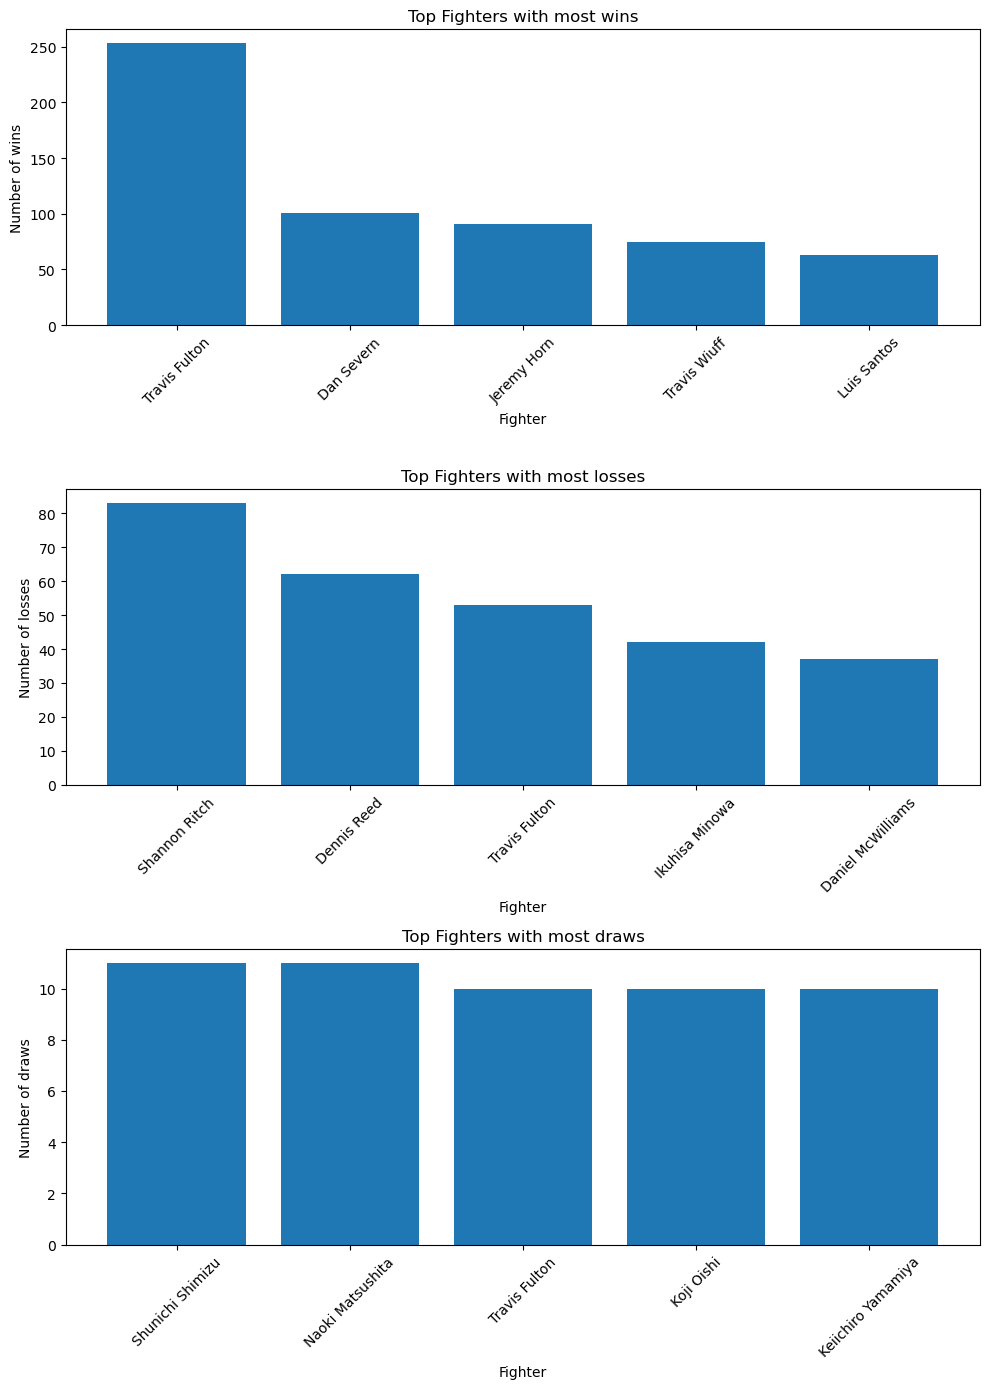

In [21]:
top_wins = fighters.sort_values('Wins', ascending=False).head(5)
top_losses = fighters.sort_values('Losses', ascending=False).head(5)
top_draws = fighters.sort_values('Draws', ascending=False).head(5)

fig, axs = plt.subplots(3, 1, figsize=(10, 14))

categories = ['Wins', 'Losses', 'Draws']
top_fighters = [top_wins, top_losses, top_draws]

for i, ax in enumerate(axs):
    ax.bar(top_fighters[i]['Full_Name'], top_fighters[i][categories[i]])
    ax.set_title(f'Top Fighters with most {categories[i].lower()}')
    ax.set_xlabel('Fighter')
    ax.set_ylabel(f'Number of {categories[i].lower()}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

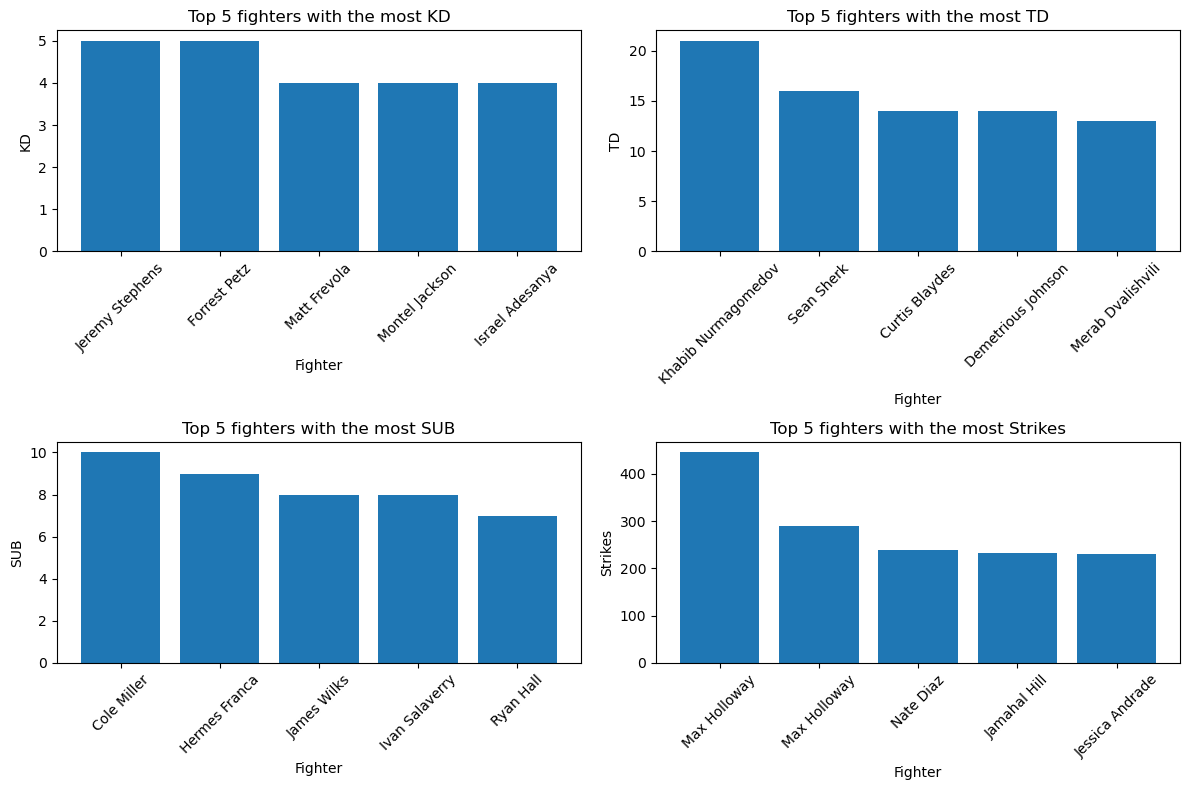

In [22]:
categories = ['KD', 'TD', 'SUB', 'Strikes']

top_fighters = {category: {} for category in categories}

for category in categories:
    top_fighters[category] = events.nlargest(5, f'{category}_Fighter1')[['Fighter1', 'Fighter2', f'{category}_Fighter1', f'{category}_Fighter2']]

fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

for i, category in enumerate(categories):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    fighter_names = top_fighters[category]['Fighter1'].tolist()
    statistic_values = top_fighters[category][f'{category}_Fighter1'].tolist()
    x_pos = range(len(fighter_names))

    ax.bar(x_pos, statistic_values)
    ax.set_xlabel('Fighter')
    ax.set_ylabel(f'{category}')
    ax.set_title(f'Top 5 fighters with the most {category}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(fighter_names, rotation=45) 

plt.show()

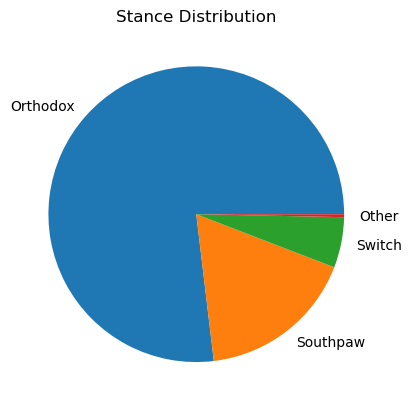

In [23]:
import matplotlib.pyplot as plt

# Obliczenie liczby wystąpień poszczególnych stanowisk
stance_counts = fighters['Stance'].value_counts()

# Określenie progu dla stanowisk rzadkich
threshold = 0.05
rare_threshold = threshold * stance_counts.sum()

# Zidentyfikowanie kategorii rzadkich
rare_stances = stance_counts[stance_counts < rare_threshold]

# Grupowanie kategorii rzadkich jako "inne"
other_count = rare_stances.sum()
stance_counts = stance_counts[~stance_counts.index.isin(rare_stances.index)]
stance_counts['Other'] = other_count

# Wygenerowanie wykresu kołowego
fig, ax = plt.subplots()
ax.pie(stance_counts, labels=stance_counts.index)
ax.set_title('Stance Distribution')

plt.show()


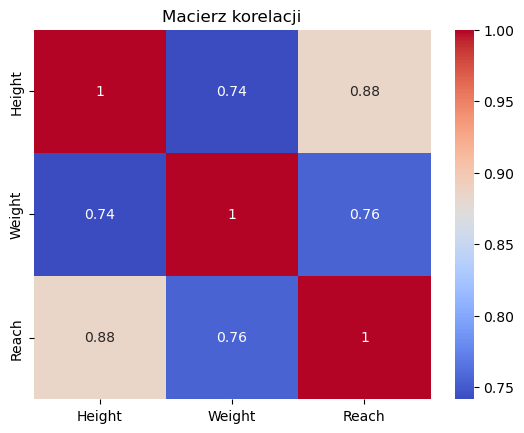

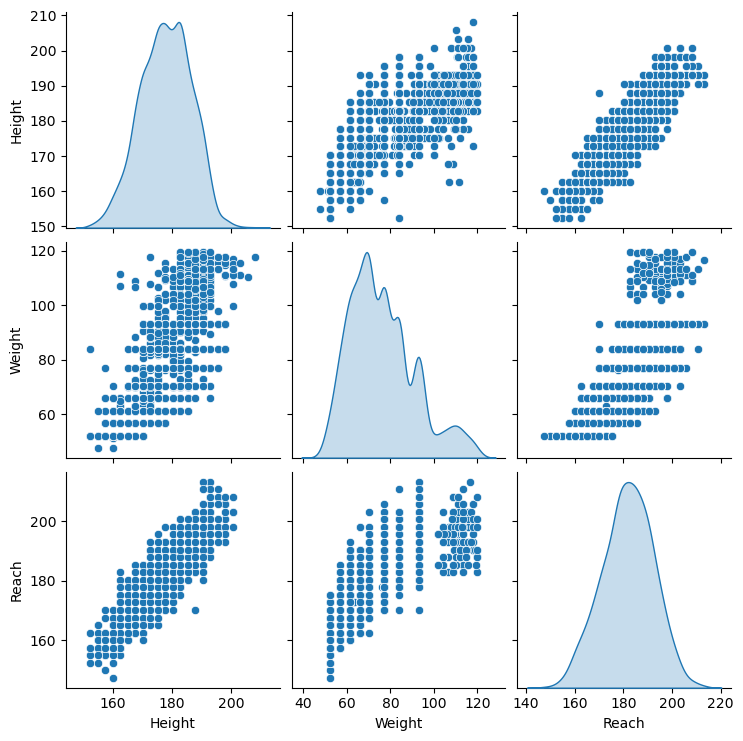

In [24]:
# Przygotowanie danych
data = fighters[['Height', 'Weight', 'Reach']].copy()
data['Reach'] = data['Reach'].replace('--', np.nan).astype(float)
data = data[data['Weight'] <= 120]  # Wykluczenie wag powyżej 200 kg

# Obliczenie macierzy korelacji
correlation_matrix = data.corr()

# Wyświetlenie macierzy korelacji
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')

# Wyświetlenie wykresów rozrzutu
sns.pairplot(data, vars=['Height', 'Weight', 'Reach'], diag_kind='kde')

plt.show()

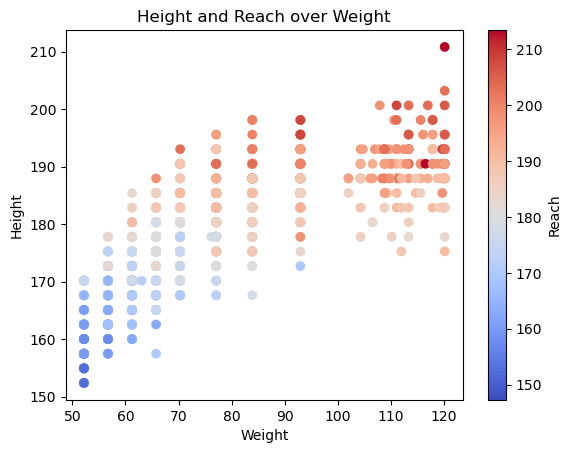

In [25]:
height = fighters['Height']
reach = fighters['Reach']
weight = fighters['Weight']

fig, ax = plt.subplots()
scatter = ax.scatter(weight, height, c=reach, cmap='coolwarm')
ax.set_xlabel('Weight')
ax.set_ylabel('Height')
ax.set_title('Height and Reach over Weight')
cbar = plt.colorbar(scatter, ax=ax, label='Reach')

plt.show()